In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

## 🧾 Etapa 1 — Download do Dataset  
Foi utilizado o **Jena Climate Dataset**, disponível no Kaggle, que contém medições meteorológicas realizadas a cada 10 minutos por vários anos.  
O download é feito automaticamente via `kagglehub`, que facilita o processo sem precisar configurar tokens de API manualmente.

**Referência:**  
- [Kaggle Dataset: Jena Climate](https://www.kaggle.com/datasets/mnassrib/jena-climate)  
- [KaggleHub Documentation](https://pypi.org/project/kagglehub/)  


In [8]:
import kagglehub

# (precisa do pacote 'kagglehub')
path = kagglehub.dataset_download("mnassrib/jena-climate")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'jena-climate' dataset.
Path to dataset files: /kaggle/input/jena-climate


## 📊 Etapa 2 — Leitura e Inspeção dos Dados  
Após o download, o arquivo CSV é carregado com **Pandas** para inspeção das colunas e amostras iniciais.  
As principais colunas são:  
- `Date Time`: Data e hora da medição.  
- `T (degC)`: Temperatura.  
- `p (mbar)`: Pressão atmosférica.  
- `rh (%)`: Umidade relativa.  
- `wv (m/s)`: Velocidade do vento.  
- `VPdef (mbar)`: Déficit de pressão de vapor.  
- `sh (g/kg)`: Umidade específica.  
- `rho (g/m**3)`: Densidade do ar.  

Esses atributos são usados como *features* para prever a temperatura futura.



In [10]:

# Localiza o arquivo CSV dentro da pasta baixada
csv_files = [f for f in os.listdir(path) if f.endswith(".csv")]
assert len(csv_files) > 0, "Nenhum arquivo CSV encontrado!"
csv_path = os.path.join(path, csv_files[0])
print("CSV path:", csv_path)

CSV path: /kaggle/input/jena-climate/jena_climate_2009_2016.csv


In [11]:
df = pd.read_csv(csv_path)
print("Formato:", df.shape)
print("Colunas:", df.columns.tolist())
df.head(3)


Formato: (420551, 15)
Colunas: ['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6


## 🧮 Etapa 3 — Pré-processamento e Normalização  
Primeiro, converte-se a coluna de data (`Date Time`) para o tipo `datetime` e a define como índice temporal.  
Depois, realiza-se a **normalização** das variáveis contínuas — ou seja, cada coluna é transformada para ter média 0 e desvio padrão 1:

$$
x_{norm} = \frac{x - \mu}{\sigma}
$$

A normalização é importante porque:  
- Faz com que todas as variáveis tenham a mesma escala.  
- Evita que features com valores altos dominem o treinamento.  
- Acelera a convergência do modelo e melhora a estabilidade numérica.

**Referências:**  
- [Why Normalizing Data Is Important for Machine Learning](https://towardsdatascience.com/why-normalizing-data-is-crucial-for-machine-learning-9535e85c68f6) — *Towards Data Science*  
- [Data Normalization in Machine Learning Explained](https://machinelearningmastery.com/how-to-normalize-and-standardize-machine-learning-data-in-python-with-scikit-learn/) — *Machine Learning Mastery*  


In [13]:

# Selecionar features relevantes (inspirado no tutorial oficial Keras)
feature_keys = [
    "p (mbar)", "T (degC)", "rh (%)", "VPdef (mbar)",
    "sh (g/kg)", "rho (g/m**3)", "wv (m/s)"
]
data = df[feature_keys].copy()

In [14]:
# Normalização com média e desvio do conjunto de treino
split_fraction = 0.715
train_split = int(split_fraction * len(data))
data_values = data.values.astype("float32")

In [15]:
mean = data_values[:train_split].mean(axis=0)
std = data_values[:train_split].std(axis=0)
data_norm = (data_values - mean) / std

## ⏳ Etapa 4 — Criação dos Datasets Temporais  
O conjunto é dividido em **sequências temporais**, onde cada janela de tempo contém um histórico de observações que será usado para prever um valor futuro.  
Neste caso:  
- São usados **5 dias de dados passados (720 passos)** para prever a temperatura **12 horas à frente (72 passos)**.  

Essa técnica é chamada de **janela deslizante (sliding window)** e é amplamente usada em modelagem de séries temporais para capturar padrões sazonais e tendências.

**Referência:**  
- [A Guide to Time Series Forecasting with LSTM](https://towardsdatascience.com/time-series-forecasting-with-lstm-2f2b6a9a34a7) — *Towards Data Science*  


In [16]:
step = 6      # 6 * 10min = 1h (sampling rate)
past = 720    # 5 dias
future = 72   # 12 horas
sequence_length = int(past / step)


In [17]:
# Construir datasets de treino e validação
start = past + future
x_train = data_norm[:train_split]
y_train = data_norm[start:train_split + start, 1:2]  # coluna 1 = temperatura normalizada

dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train[:- (past + future)],
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=256,
)

val_data = data_norm[train_split:]
x_val = val_data[:- (past + future)]
y_val = data_norm[train_split + start - train_split :, 1:2]

dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=256,
)

## 🧠 Etapa 5 — Definição do Modelo RNN  
O modelo utiliza uma **Rede Neural Recorrente (RNN)**, composta por:  
- Uma camada `SimpleRNN` com 32 unidades ocultas.  
- Uma camada `Dense` de saída com 1 neurônio, responsável por prever a temperatura.  

As RNNs são ideais para esse tipo de tarefa, pois conseguem aprender dependências temporais entre observações consecutivas — ou seja, entendem que o valor atual depende dos valores anteriores.

**Referências:**  
- [Understanding Recurrent Neural Networks (RNNs)](https://towardsdatascience.com/understanding-recurrent-neural-networks-f3f53f74b2fa) — *Towards Data Science*  
- [Keras RNN Layer Documentation](https://keras.io/api/layers/recurrent_layers/simple_rnn/)  


In [18]:
from tensorflow import keras

inputs = keras.layers.Input(shape=(sequence_length, len(feature_keys)))
rnn = keras.layers.SimpleRNN(32)(inputs)
out = keras.layers.Dense(1)(rnn)
model = keras.Model(inputs, out)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 7)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313 (5.13 KB)

 Trainable params: 1,313 (5.13 KB)

 Non-trainable params: 0 (0.00 B)

## 🏋️ Etapa 6 — Treinamento do Modelo  
O modelo é treinado usando:  
- **Otimizador:** Adam (eficiente para problemas não convexos).  
- **Função de perda:** MSE (Erro Quadrático Médio).  
- **Métrica:** RMSE (Raiz do Erro Quadrático Médio).  

O **RMSE** é usado porque mostra o erro médio em **unidades da variável original (°C)** — facilitando a interpretação do resultado.  
Além disso, penaliza erros grandes mais severamente, tornando-o uma boa escolha para previsões meteorológicas.

$$
RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}
$$

**Referências:**  
- [Understanding RMSE and MAE in Machine Learning](https://towardsdatascience.com/understanding-rmse-and-mae-in-machine-learning-8c2d405d1c1a) — *Towards Data Science*  
- [How to Choose the Right Evaluation Metric for Machine Learning Models](https://machinelearningmastery.com/regression-metrics-for-machine-learning/) — *Machine Learning Mastery*  


In [19]:
epochs = 10
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
)


Epoch 1/10
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 93s 78ms/step - loss: 0.6055 - rmse: 0.7136 - val_loss: 2.1721 - val_rmse: 1.4738
Epoch 2/10
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 93s 80ms/step - loss: 0.1726 - rmse: 0.4144 - val_loss: 2.1872 - val_rmse: 1.4789
Epoch 3/10
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 89s 76ms/step - loss: 0.1541 - rmse: 0.3914 - val_loss: 2.1356 - val_rmse: 1.4614
Epoch 4/10
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 93s 79ms/step - loss: 0.1506 - rmse: 0.3865 - val_loss: 2.1203 - val_rmse: 1.4561
Epoch 5/10
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 93s 80ms/step - loss: 0.1558 - rmse: 0.3913 - val_loss: 2.0908 - val_rmse: 1.4460
Epoch 6/10
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 93s 79ms/step - loss: 0.1437 - rmse: 0.3768 - val_loss: 2.1545 - val_rmse: 1.4678
Epoch 7/10
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 91s 78ms/step - loss: 0.1398 - rmse: 0.3730 - val_loss: 1.8468 - val_rmse: 1.3590
Epoch 8/10
1169/1169 ━━━━━━━━━━━━━━━━━━━━ 91s 78ms/step - loss: 0.1807 - rmse: 0.4182 - val_loss: 2.1872 - val_rmse: 1.4789
Epoch 9/

## 📈 Etapa 7 — Avaliação e Interpretação dos Resultados  
Após o treino, o modelo é avaliado com base no **RMSE de validação** e na comparação entre os valores **reais e previstos**.  
Um gráfico é gerado para mostrar a proximidade entre as duas curvas — quanto mais próximas, melhor a capacidade preditiva da RNN.  

Esse tipo de visualização é essencial para avaliar se o modelo está capturando corretamente as variações temporais da temperatura.



In [20]:
eval_res = model.evaluate(dataset_val)
print("Resultados (MSE, RMSE):", eval_res)

463/463 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - loss: 2.2207 - rmse: 1.4717
Resultados (MSE, RMSE): [2.1723437309265137, 1.473887324333191]


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━

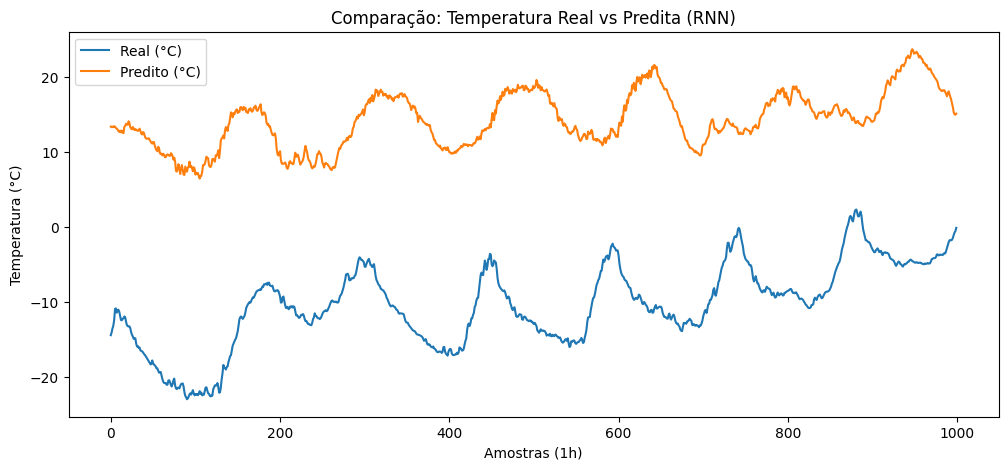

In [21]:
y_true_list, y_pred_list = [], []
for Xb, Yb in dataset_val:
    y_true_list.append(Yb.numpy().reshape(-1))
    y_pred_list.append(model.predict(Xb).reshape(-1))

y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

# Desnormaliza para °C
temp_mean, temp_std = mean[1], std[1]
y_true_c = y_true * temp_std + temp_mean
y_pred_c = y_pred * temp_std + temp_mean

# Plot comparativo
n_plot = 1000 if len(y_true_c) >= 1000 else len(y_true_c)
plt.figure(figsize=(12,5))
plt.plot(y_true_c[:n_plot], label='Real (°C)')
plt.plot(y_pred_c[:n_plot], label='Predito (°C)')
plt.title("Comparação: Temperatura Real vs Predita (RNN)")
plt.xlabel("Amostras (1h)")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.show()

## 🧩 Etapa 9 — Cálculo e Interpretação do RMSE Final  
Por fim, o **RMSE final (em °C)** é calculado sobre as previsões.  
Esse valor expressa, em média, o erro do modelo em relação à temperatura real.  
Valores menores de RMSE indicam melhor desempenho.  

Esse resultado serve também como **baseline** para comparação com outros modelos, como **LSTM** e **GRU**, que costumam ter melhor performance em séries temporais com dependências longas.



In [22]:
rmse_c = np.sqrt(np.mean((y_true_c - y_pred_c)**2))
print(f"RMSE final (°C): {rmse_c:.3f}")

RMSE final (°C): 12.727
